# Import appropriate modules

In [43]:
import numpy as np
from numpy.linalg import eigh
from numpy import load
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3e}".format(x)})

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import Rb87Cs133

import scipy.constants
from scipy.linalg import expm

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.gridspec import GridSpec

from tqdm import tqdm, trange
import math
import itertools

from numba import jit, njit
from numba import njit
from numba_progress import ProgressBar

# plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200
# plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}\usepackage{cmbright}\usepackage{mathtools}')

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

## Defining parameters

In [44]:
MOLECULE_STRING = "Rb87Cs133"
MOLECULE = Rb87Cs133
N_MAX=2

settings_string = f'{MOLECULE_STRING}NMax{N_MAX}'
print(settings_string)

H_BAR = scipy.constants.hbar
muN = scipy.constants.physical_constants['nuclear magneton'][0]

I1 = MOLECULE["I1"]
I2 = MOLECULE["I2"]
I1_D = round(2*I1)
I2_D = round(2*I2)

D_0 = MOLECULE["d0"]

PER_MN = round((2*I1+1)*(2*I2+1))
N_STATES = PER_MN * (N_MAX+1)**2
F_D_MAX = 2*N_MAX + I1_D + I2_D
print(f"{N_STATES} states loaded from molecule.")

GAUSS = 1e-4 # T

Rb87Cs133NMax2
288 states loaded from molecule.


# Load precomputed results

In [45]:
print("Loading precomputed data...")
data = np.load(f'../precomputed/{settings_string}.npz')

B=data['b']
B_MIN = B[0]
B_MAX = B[-1]
B_STEPS = len(B)

ENERGIES = data['energies']
STATES = data['states']

UNCOUPLED_LABELS_D=data['uncoupled_labels_d']

LABELS_D=data['labels_d']
LABELS_DEGENERACY = data['labels_degeneracy']
STATE_JUMP_LIST = data['state_jump_list']

TRANSITION_LABELS_D = data['transition_labels_d']
TRANSITION_INDICES = data['transition_indices']
EDGE_JUMP_LIST = data['edge_jump_list']


MAGNETIC_MOMENTS=data['magnetic_moments'] 

COUPLINGS_SPARSE=data['couplings_sparse']
TRANSITION_GATE_TIMES_POL = data['transition_gate_times_pol']
TRANSITION_GATE_TIMES_UNPOL = data['transition_gate_times_unpol']

CUMULATIVE_TIME_FROM_INITIALS_POL = data['cumulative_pol_time_from_initials']
PREDECESSOR_POL = data['predecessor_pol_time_from_initials']

CUMULATIVE_TIME_FROM_INITIALS_UNPOL = data['cumulative_unpol_time_from_initials']
PREDECESSOR_UNPOL = data['predecessor_unpol_time_from_initials']

PAIR_RESONANCE = data['pair_resonance']

def label_degeneracy(N,MF_D):
    return LABELS_DEGENERACY[N,(MF_D+F_D_MAX)//2]

@jit(nopython=True)
def label_d_to_node_index(N,MF_D,d):
    return STATE_JUMP_LIST[N,(MF_D+F_D_MAX)//2]+d

@jit(nopython=True)
def label_d_to_edge_indices(N,MF_D,d): # Returns the start indices of P=0,P=1,P=2, and the next edge
    return EDGE_JUMP_LIST[label_d_to_node_index(N,MF_D,d)]

INITIAL_STATE_LABELS_D = MOLECULE["StartStates_D"]
INITIAL_STATE_INDICES = np.array([label_d_to_node_index(*label_d) for label_d in INITIAL_STATE_LABELS_D])
N_INITIAL_STATES = len(INITIAL_STATE_INDICES)
print("Loaded precomputed data.")

Loading precomputed data...
Loaded precomputed data.


# Helper Functions

In [46]:
def label_d_to_string(label_d):
    n = label_d[0]
    mf_d = label_d[1]
    mf_frac = mf_d%2
    i = label_d[2]
    if mf_frac == 0:
        return f"({n},{mf_d//2},{i})"
    else:
        mf_whole= (mf_d - np.sign(mf_d))//2
        return f"({n},{mf_whole}.5,{i})"

def label_d_to_latex_string(label_d):
    n = label_d[0]
    mf_d = label_d[1]
    mf_frac = mf_d%2
    i = label_d[2]
    if mf_frac == 0:
        return r'|{},{}\rangle_{{{}}}'.format(n,mf_d//2,i)
    else:
        mf_whole= (mf_d - np.sign(mf_d))//2
        return r'|{},{}.5\rangle_{{{}}}'.format(n,mf_whole,i)
    
def fid_to_string(fid):
    return f"{fid:.4f}({fidelity(fid,d=9):.1f})"

In [47]:
def reachable_above_from(N,MF_D):
    sigma_plus_reachable = [(N+1,MF_D-2,i) for i in range(label_degeneracy(N+1,MF_D-2))]
    pi_reachable = [(N+1,MF_D,i) for i in range(label_degeneracy(N+1,MF_D))]
    sigma_minus_reachable = [(N+1,MF_D+2,i) for i in range(label_degeneracy(N+1,MF_D+2))]
    return (sigma_plus_reachable + pi_reachable + sigma_minus_reachable)

def twice_average_fidelity(k,g):
    return ((1 + g**2)**2 + 8*k**2*(-1 + 2*g**2) + 16*k**4)/((1 + g**2)**3 + (-8 + 20*g**2 + g**4)*k**2 + 16*k**4)

def simple_fidelity(k,g):
    g2 = g**2
    k2 = k**2
    return  1 - (4*g2+g2**2)/(16*k2)

def maximum_fidelity(k,g):
    phi = np.arccos((k*(18-9*g**2-8*k**2))/(3+3*g**2+4*k**2)**(3/2))/3
    denominator = 54*((1+g**2)**3+(-8+20*g**2+g**4)*k**2+16*k**4)
    numerator = (
                 36*(g**4+(1-4*k**2)**2+2*g**2*(1+8*k**2))
               + 32*k    *(3+3*g**2+4*k**2)**(3/2) *np.cos(phi)
               - 64*k**2 *(3+3*g**2+4*k**2)        *np.cos(2*phi) 
               -  4      *(3+3*g**2+4*k**2)**2     *np.cos(4*phi)
                )
    return numerator/denominator

def fidelity(ts,d=8):
    return -np.log10(1-ts+10**(-d))

In [48]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def field_to_bi(gauss):
    return find_nearest(B,gauss*GAUSS)

In [49]:
@jit(nopython=True)
def label_pair_to_edge_index(label1,label2):
    first_indices = label_d_to_edge_indices(label1[0],label1[1],label1[2])
    section = 3*((label2[0] - label1[0]) < 0) + [0,1,2][(label2[0] - label1[0])*(label1[1] - label2[1])//2]
    return first_indices[section]+label2[2]

# TRANSITION_LABELS_D[label_pair_to_edge_index((1,4,3),(0,2,1))]
TRANSITION_LABELS_D[label_pair_to_edge_index(np.array([1,4,3]),np.array([0,2,1]))]

array([1, 4, 3, 0, 2, 1])

# Simulator

In [108]:
# Driven couplings between states
chosen_states_coupling_labels = np.array([(1,6,8),(0,4,3),(1,4,9)])
chosen_coupling_labels = [
    # (chosen_states_coupling_labels[0],chosen_states_coupling_labels[1]),
    (chosen_states_coupling_labels[1],chosen_states_coupling_labels[2]),
    # (chosen_states_coupling_labels[3],chosen_states_coupling_labels[2]),
    # (chosen_states_coupling_labels[0],chosen_states_coupling_labels[3]),
]

# With what desired rabi period
global_pulse_time = 1018.57 * 1e-6 #s
chosen_pulse_time = [global_pulse_time]*len(chosen_coupling_labels)

# At what magnetic field
chosen_bi = field_to_bi(930)

# Only simulate other states that have strong off resonant coupling
cutoff = 0.9999999 # =0 for only these =1 for all states
        
# Simulation resolution
T_STEPS =  [803989,314927,195931,65519,41443,21319,9391,50][3]*2

# Simulation time length (how many Rabi periods to show)
TIME = chosen_pulse_time[0]*2

In [109]:
chosen_state_labels = []
# example_points = []

needed_states = np.full(N_STATES, False)
for l in chosen_states_coupling_labels:
    ni = label_d_to_edge_indices(*l)
    nl = TRANSITION_INDICES[ni[0]:ni[6]][:,1]
    needed_states[nl] = True 
    # example_points.append()

chosen_states_labels = LABELS_D[needed_states]

chosen_states_coupling_subindices = [np.where((chosen_states_labels[:, 0] == N) & (chosen_states_labels[:, 1] == MF) & (chosen_states_labels[:, 2] == k))[0][0] for N,MF,k in chosen_states_coupling_labels]
chosen_states_indices = np.array([label_d_to_node_index(*label) for label in chosen_states_labels])
chosen_number_of_states = len(chosen_states_indices)

In [110]:
# example_points = []

# for (al,bl),pt in zip(chosen_coupling_labels, chosen_pulse_time):
    

# if cutoff == 0:
#     chosen_states_labels = chosen_states_coupling_labels
# elif cutoff == 1:
#     chosen_states_labels = LABELS_D
# else:
#     needed_states = np.full(N_STATES, False)
#     print(f"These states passed the cutoff ({cutoff}):")
#     for (al,bl),pt in zip(chosen_coupling_labels, chosen_pulse_time):
#         ai = label_to_state_no(*al)
#         bi = label_to_state_no(*bl)
#         ks_up = np.abs((ENERGIES[chosen_bi, :] - ENERGIES[chosen_bi, bi, None]) * pt / scipy.constants.h)
#         ks_down = np.abs((ENERGIES[chosen_bi, :] - ENERGIES[chosen_bi, ai, None]) * pt / scipy.constants.h)

#         gs_unpolarised_up = np.abs(COUPLINGS[chosen_bi, ai, :]/COUPLINGS[chosen_bi, ai, bi])
#         gs_unpolarised_down = np.abs(COUPLINGS[chosen_bi, bi, :]/COUPLINGS[chosen_bi, ai, bi])

#         fidelities_unpolarised_up = twice_average_fidelity(ks_up,gs_unpolarised_up)
#         fidelities_unpolarised_down = twice_average_fidelity(ks_down,gs_unpolarised_down)
        
#         fidelities_unpolarised_up_simple = simple_fidelity(ks_up,gs_unpolarised_up)
#         fidelities_unpolarised_down_simple = simple_fidelity(ks_down,gs_unpolarised_down)
        
#         needed_states = needed_states + (fidelities_unpolarised_up < cutoff) + (fidelities_unpolarised_down < cutoff)
#         chosen_states_labels = LABELS_D[needed_states]
        
#         for k_up,g_unpolarised_up,f_up,f_up_s in zip(ks_up,gs_unpolarised_up,fidelities_unpolarised_up,fidelities_unpolarised_up_simple):
#             if f_up < cutoff:
#                 print(f_up,f_up_s)
#                 example_points.append((k_up,g_unpolarised_up,1))
                
#         for k_down,g_unpolarised_down,f_down,f_down_s in zip(ks_down,gs_unpolarised_down,fidelities_unpolarised_down,fidelities_unpolarised_down_simple):
#             if f_down < cutoff:
#                 print(f_down,f_down_s)
#                 example_points.append((k_down,g_unpolarised_down,1))
                

#     print(chosen_states_labels)
    

    
# chosen_states_coupling_subindices = [np.where((chosen_states_labels[:, 0] == N) & (chosen_states_labels[:, 1] == MF) & (chosen_states_labels[:, 2] == k))[0][0] for N,MF,k in chosen_states_coupling_labels]
# chosen_states_indices = np.array([label_to_state_no(*label) for label in chosen_states_labels])
# chosen_number_of_states = len(chosen_states_indices)

In [111]:
# Compute further constants and indices from molecular parameters
k_exp_range = (-7,7)
g_exp_range = (-7,7)
ks = np.logspace(*k_exp_range,1000)
gs = np.logspace(*g_exp_range,1000)
ks, gs = np.meshgrid(ks,gs)
twice_average_fidelities = twice_average_fidelity(ks,gs)
simple_fidelities = simple_fidelity(ks,gs)

/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_30815/1854515021.py:17: RuntimeWarning: invalid value encountered in log10
  normalised_fidelies = (np.log10(1/(1 - (1 - 10**(-k))*fidelities - 0.5*10**(-k)) - 1))/(2*np.log10(2*10**k - 1)) + 1/2


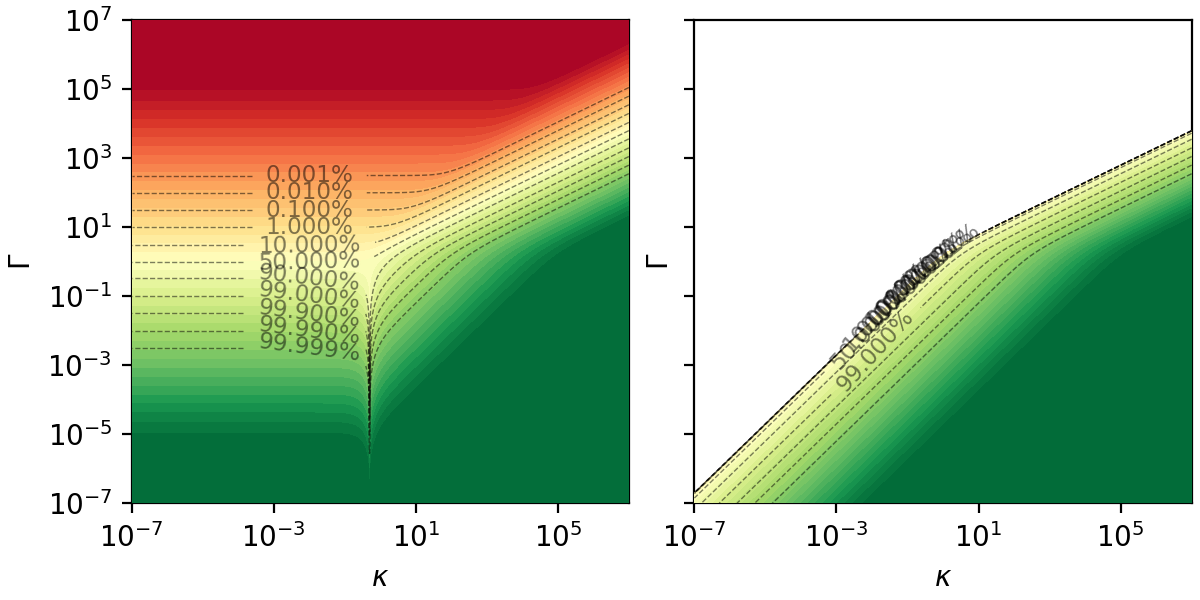

In [112]:
fig, (axl,axr) = plt.subplots(1,2,figsize=(6,3),constrained_layout=True,sharex=True,sharey=True)

Norm  = matplotlib.colors.Normalize(vmin=0, vmax=1)

noted_levels=[0.00001,0.0001,0.001,0.01,0.1,0.5,0.9,0.99,0.999,0.9999,0.99999]

for ax, fidelities in [(axl,twice_average_fidelities),(axr,simple_fidelities)]:
    ax.set_ylabel('$\Gamma$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(10**k_exp_range[0],10**k_exp_range[1])
    ax.set_ylim(10**g_exp_range[0],10**g_exp_range[1])
    # ax.set_xlim(1,1000)
    # ax.set_ylim(0.0001,100)
    ax.set_xlabel('$\kappa$')
    k=10
    normalised_fidelies = (np.log10(1/(1 - (1 - 10**(-k))*fidelities - 0.5*10**(-k)) - 1))/(2*np.log10(2*10**k - 1)) + 1/2
    cf = ax.contourf(ks,gs,normalised_fidelies,40,cmap='RdYlGn',norm=Norm,alpha=1,zorder=10)
    CS1 = ax.contour(ks,gs,fidelities,noted_levels, colors='k',linestyles='dashed',linewidths=0.5,alpha=0.5,zorder=20)

    fmt = {}
    strs = [f"{n*100:.3f}%" for n in noted_levels]
    for l, s in zip(CS1.levels, strs):
        fmt[l] = s

    labelpositions = [(0.01,np.sqrt(1/n-1)) for n in noted_levels]
    ax.clabel(CS1, CS1.levels, fmt=fmt,manual=labelpositions,fontsize='small')

#     for k,g,_ in example_points:
#         ax.plot(k, g, 'ko',markersize=5,zorder=100,mfc='none')

In [113]:
# Get Angular Frequency Matrix Diagonal for each B
all_angular = ENERGIES[:, chosen_bi].real / H_BAR # [state]
angular = all_angular[chosen_states_indices]

# Form coupling matrix
couplings = np.zeros((chosen_number_of_states,chosen_number_of_states))
for i in range(chosen_number_of_states):
    ai = chosen_states_indices[i]
    for j in range(chosen_number_of_states):
        bi = chosen_states_indices[j]
        la = LABELS_D[ai]
        lb = LABELS_D[bi]
        if abs(la[0]-lb[0]) != 1 or abs(la[1]-lb[1]) > 2:
            continue
        edge_index = label_pair_to_edge_index(la,lb)
        couplings[i,j] = COUPLINGS_SPARSE[edge_index,chosen_bi]
        
# Get driving frequencies & polarisations
driving = []
E_i = []
for (l1,l2), pulse_time in zip(chosen_coupling_labels, chosen_pulse_time):
    i1=label_d_to_node_index(*l1)
    i2=label_d_to_node_index(*l2)
    driving.append(np.abs(all_angular[i1]-all_angular[i2]))
    E_i.append((2*np.pi*H_BAR) / (D_0 * COUPLINGS_SPARSE[label_pair_to_edge_index(l1,l2),chosen_bi] * pulse_time))
driving = np.array(driving)
print("Driving (rad/s):", driving)
E_i = np.array(E_i,dtype=np.double)
print("E (V/m):", E_i)

# Construct times
times, DT = np.linspace(0,TIME,num=T_STEPS,retstep=True)

# Construct kinetic time step operator (Matrix Diagonal)
T_OP_DIAG = np.exp(-(1j) * angular * DT/2 )

# Construct potential fixed part time step operator 
ORDER = 10
V_TI_M = (-(1j)*D_0*couplings*DT)/H_BAR
V_TI_M_POWS = np.array([np.linalg.matrix_power(V_TI_M, i)/np.math.factorial(i) for i in range(ORDER)])

# Construct state vector
state_vector = np.zeros((T_STEPS,chosen_number_of_states), dtype=np.cdouble)
state_vector[0,chosen_states_coupling_subindices[0]] = 1/np.sqrt(2)
state_vector[0,chosen_states_coupling_subindices[2]] = 1/np.sqrt(2)

for t_num in trange(T_STEPS-1):
    pres = E_i*np.cos(driving*times[t_num])
    V_TD_POWS = np.sum(pres)**(np.arange(ORDER))
    V_OP = np.sum(V_TI_M_POWS*V_TD_POWS[:,None,None],axis=0)
    
    DU = T_OP_DIAG[:,None] * V_OP[:,:] * T_OP_DIAG[None,:]
    state_vector[t_num+1] = DU @ state_vector[t_num]

resolution=20
probabilities = np.abs(state_vector[::resolution,:])**2

Driving (rad/s): [6.159e+09]
E (V/m): [-2.768e-01]


100%|█████████████████████████████████| 131037/131037 [01:09<00:00, 1886.29it/s]


0.5000000000


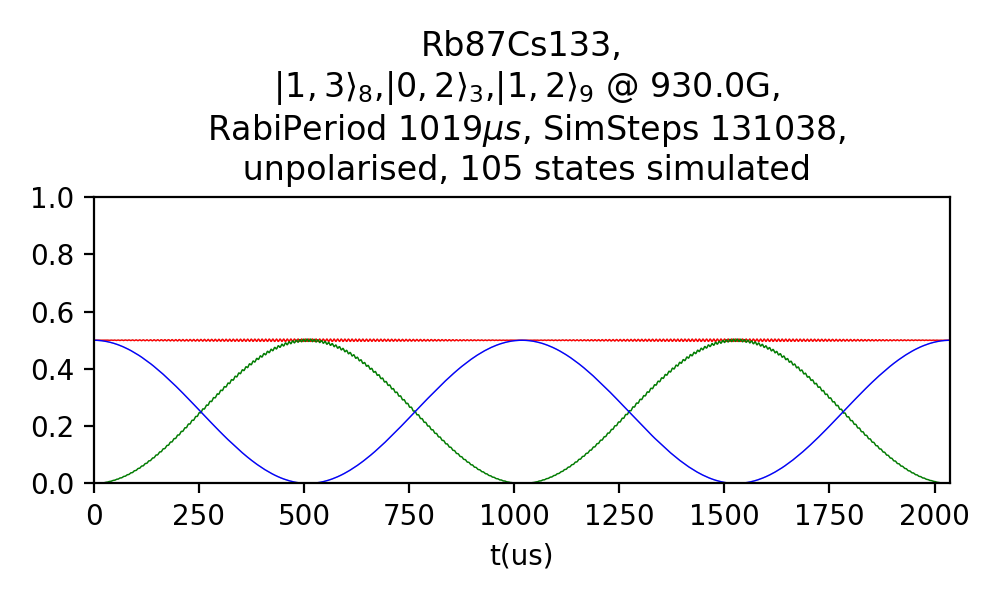

In [114]:
# Plot results
fig,ax = plt.subplots(figsize=(5,3))
ax.set_xlabel('t(us)')
ax.set_ylim(0,1)
ax.set_xlim(0,TIME*1e6)
states_string = ','.join([f'${label_d_to_latex_string(label)}$' for label in chosen_states_coupling_labels])
ax.set_title('{},\n {} @ {}G,\n RabiPeriod {}$\mu s$, SimSteps {},\n unpolarised, {} states simulated'
             .format(MOLECULE_STRING,
                     states_string,
                     f"{B[chosen_bi]/GAUSS:.1f}",
                     round(global_pulse_time*1e6),
                     T_STEPS,
                     chosen_number_of_states))

c = ['red','green','blue','purple','grey','grey']
ax.plot(times[::resolution]*1e6,probabilities[:,:],c='grey',linewidth=0.5,alpha=0.5);
for i,state_subindex in enumerate(chosen_states_coupling_subindices):
    ax.plot(times[::resolution]*1e6,probabilities[:,state_subindex],c=c[i],linewidth=0.5);
    
print(f"{np.max(probabilities[:,chosen_states_coupling_subindices[2]]):.10f}")
fig.savefig(f'../images/{MOLECULE_STRING}-2-state-qubit-sim-a.pdf')

# 0.9956479464
# 0.9954616013
# Hyp: 0.9909437997